In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter

In [2]:
class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

In [3]:
def load_fits(galaxy_name, line_name, PI_name, ver, r):

    loaddir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/Raw/' + galaxy_name + '/' + line_name + '/' + PI_name + '/'
    
    if(ver != ''):
        loaddir = loaddir + ver + '/'

    savedir = loaddir + 'r=' + str(r) + '/'

    fits_name = galaxy_name + '_' + line_name + '.fits'
    fits_spec_name = galaxy_name + '_' + line_name + '_r={}.fits'.format(str(r))
    
    hdulist = fits.open(loaddir + fits_name)
    hdulist_spec = fits.open(savedir + fits_spec_name)
    
    return hdulist, hdulist_spec, savedir

In [4]:
def renormalize_spectra(wavelengths, central_fluxes_unfiltered):
    
    central_fluxes_unfiltered = [flux*(10**(-26)) for flux in central_fluxes_unfiltered]

    c = 3*10**8

    for i in range(0, len(wavelengths)):

        wavelength = wavelengths[i]

        central_fluxes_unfiltered[i] = central_fluxes_unfiltered[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))

    central_fluxes_unfiltered = np.array(central_fluxes_unfiltered)
    
    return central_fluxes_unfiltered

In [5]:
def plot_unfiltered_spectrum(wavelengths, central_fluxes_unfiltered, lower_ind, upper_ind, savedir):
    
    fig, ax = plt.subplots(figsize = (18, 13))

    ax.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', 
            alpha = 0.3)
    ax.axvspan(wavelengths[0], wavelengths[lower_ind], color = 'red', alpha = 0.1, label = 'Masked Regions')
    ax.axvspan(wavelengths[upper_ind], wavelengths[-1], color = 'red', alpha = 0.1)

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(yfmt)

    plt.savefig(savedir + '1-unfiltered_spectrum.png')

    ax.legend(prop={'size': 30}, loc = 'upper right')

In [6]:
def filter_spectra(lower_ind, upper_ind, wavelengths, central_fluxes_unfiltered): 

    wavelengths_filtered = wavelengths[lower_ind:upper_ind+1]
    central_fluxes_filtered = central_fluxes_unfiltered[lower_ind:upper_ind+1]
    
    return wavelengths_filtered, central_fluxes_filtered

In [7]:
def identify_continuum(left_cut, right_cut, wavelengths_filtered, central_fluxes_filtered):
    
    central_fluxes_filtered_continuum = []
    
    for i in range(0, len(wavelengths_filtered)):

        wavelength = wavelengths_filtered[i]

        if(wavelength < left_cut or wavelength > right_cut):
            central_fluxes_filtered_continuum.append(central_fluxes_filtered[i])

        else:
            central_fluxes_filtered_continuum.append(float("Nan"))

    central_fluxes_filtered_continuum = np.array(central_fluxes_filtered_continuum)

    idcont = np.isfinite(central_fluxes_filtered_continuum)
    cont_params = np.polyfit(wavelengths_filtered[idcont], central_fluxes_filtered_continuum[idcont], 1)
    
    return central_fluxes_filtered_continuum, cont_params

In [8]:
def plot_filtered_spectrum_continuum_points(wavelengths_filtered, central_fluxes_filtered,
                                           central_fluxes_filtered_continuum, savedir):
    
    fig, ax = plt.subplots(figsize = (18, 13))

    ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Filtered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
    ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)

    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(yfmt)
    
    ax.legend(prop={'size': 30}, loc = 'upper right')

    plt.savefig(savedir + '2-filtered_spectrum+continuum_points.png')

In [9]:
def plot_filtered_spectrum_continuum_line(wavelengths_filtered, central_fluxes_filtered,
                                    central_fluxes_filtered_continuum, cont_params, savedir):
    
    cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]
    
    fig, ax = plt.subplots(figsize = (18, 13))

    ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Spectrum', lw = 5, color = 'orange', alpha = 0.3)
    ax.plot(wavelengths_filtered, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
    ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(yfmt)

    ax.legend(prop={'size': 30}, loc = 'upper right')

    plt.savefig(savedir + '3-filtered_spectrum + continuum_line.png')

In [10]:
def subtract_continuum(central_fluxes_filtered_continuum, cont_params, wavelengths_filtered, central_fluxes_filtered):
    
    cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]
    
    id_act = np.isnan(central_fluxes_filtered_continuum)

    wavelengths_act = wavelengths_filtered[id_act]
    central_fluxes_filtered_act = central_fluxes_filtered[id_act]
    cont_line_filtered_act = cont_line_filtered[id_act]

    central_fluxes_continuum_subtracted_act = central_fluxes_filtered_act - cont_line_filtered_act
    
    return wavelengths_act, central_fluxes_continuum_subtracted_act

In [11]:
def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [12]:
def fit_gaussian(wavelengths_act, central_fluxes_continuum_subtracted_act):
    
    heights = central_fluxes_continuum_subtracted_act/np.max(central_fluxes_continuum_subtracted_act)

    centers = wavelengths_act

    # Information about the peak in the numerical PDF
    peak_ind = np.where(heights == np.max(heights))[0][0]
    peak_height = np.max(heights)

    # mu is where the numerical PDF peaks
    mu = centers[peak_ind]

    # Estimating sigma using FWHM
    sigma = 0

    for i in range(0, peak_ind):
        if(heights[i] >= peak_height/2):
            sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
            break

    # First fit a Gaussian

    guess_params = np.array([peak_height, sigma])
    fit_params, fit_covar = optimize.curve_fit(lambda centers, peak_height, sigma: 
                                               fit_func_1(centers, peak_height, mu, sigma), 
                                               centers, heights, p0=guess_params)

    fit_params = [fit_params[0], mu, fit_params[1]]

    fit_params[0] *= np.max(central_fluxes_continuum_subtracted_act)
    
    return(fit_params)

In [13]:
def plot_continuum_subtracted_spectrum(wavelengths_act, central_fluxes_continuum_subtracted_act, savedir):
    
    fig, ax = plt.subplots(figsize = (18, 13))

    ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, label = 'Continuum Subtracted Spectrum', lw = 5, color = 'orange', alpha = 0.3)

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(yfmt)

    ax.legend(prop={'size': 20}, loc = 'upper right')

    plt.savefig(savedir + '4-continuum_subtracted_spectrum.png')

In [14]:
def overlay(wavelengths_filtered, fit_params):
    
    wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
    cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]

    fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered
    
    return wavelength_range, cont_line_filtered, fitted_central_fluxes_act

In [15]:
def plot_fit_continuum_subtracted_spectrum(wavelengths_act, fit_params, 
                                           central_fluxes_continuum_subtracted_act, savedir):
    
    wavelengths_act_range = np.arange(np.min(wavelengths_act), np.max(wavelengths_act), 0.001)
    
    fig, ax = plt.subplots(figsize = (18, 13))
    
    fitted_central_fluxes_continuum_subtracted_act = fit_func_1(wavelengths_act_range, *fit_params)
    
    ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, 
            label = 'Continuum Subtracted Observation', lw = 5, color = 'orange', alpha = 0.3)

    ax.plot(wavelengths_act_range, fitted_central_fluxes_continuum_subtracted_act, 
            label = 'Continuum Subtracted Fit', lw = 5, color = 'brown', alpha = 0.3)


    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(yfmt)

    ax.legend(prop={'size': 20}, loc = 'upper right')

    plt.savefig(savedir + '5-fit_continuum_subtracted_spectrum.png')

In [16]:
def plot_final_spectrum(wavelengths_filtered, cont_params, fit_params, savedir):
    
    fig, ax = plt.subplots(figsize = (18, 13))

    wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
    cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]

    fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered

    ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
    ax.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
    ax.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
    ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)

    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(yfmt)

    ax.legend(prop={'size': 20}, loc = 'upper right')

    plt.savefig(savedir + '6-final_spectrum.png')

In [17]:
def compute_fluxes(wavelengths_filtered, wavelength_range, cont_line_filtered, central_fluxes_filtered, 
                   fitted_central_fluxes_act):
    
    flux_continuum = np.trapz(cont_line_filtered, x = wavelength_range, dx = wav_diff)

    flux_obs = np.trapz(central_fluxes_filtered, x = wavelengths_filtered, dx = wav_diff)
    flux_obs_sub = flux_obs - flux_continuum

    flux_fit = np.trapz(fitted_central_fluxes_act, x = wavelength_range, dx = wav_diff)
    flux_fit_sub = flux_fit - flux_continuum
    
    return flux_continuum, flux_obs, flux_obs_sub, flux_fit, flux_fit_sub

In [81]:
galaxy_name = 'Mrk193'
line_name = '[OIII]'
PI_name = 'Tucker_Jones'
ver = '1'
r = 8

In [82]:
hdulist, hdulist_spec, savedir = load_fits(galaxy_name, line_name, PI_name, ver, r)

In [83]:
config = np.loadtxt(savedir + 'config.txt', comments="#", delimiter=",", unpack=False)

lower_ind = int(config[0])
upper_ind = int(config[1])
left_cut = config[2]
right_cut = config[3]

In [84]:
wavelengths = hdulist[5].data
wav_diff = np.average(wavelengths[1:] - wavelengths[:-1])

central_fluxes_unfiltered = hdulist_spec[0].data

In [85]:
central_fluxes_unfiltered = renormalize_spectra(wavelengths, central_fluxes_unfiltered)

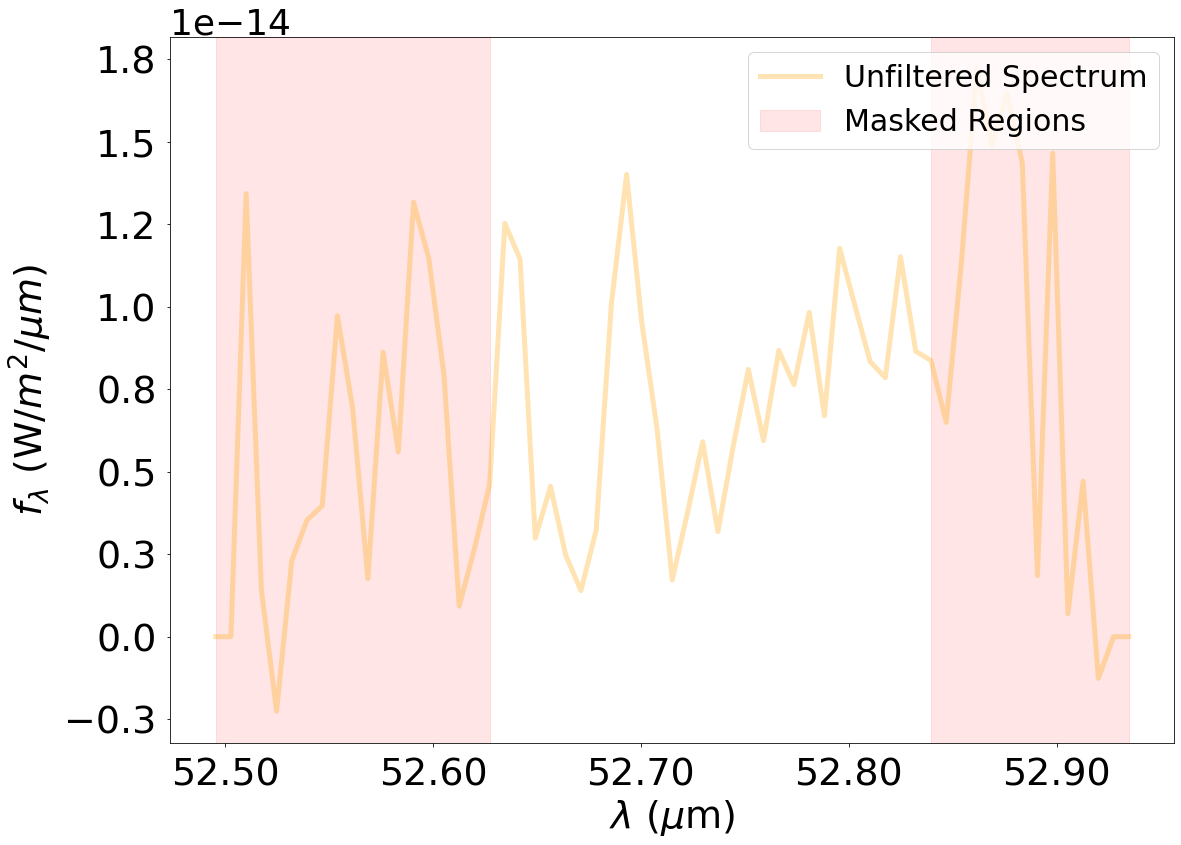

In [86]:
plot_unfiltered_spectrum(wavelengths, central_fluxes_unfiltered, lower_ind, upper_ind, savedir)

In [44]:
wavelengths_filtered, central_fluxes_filtered = filter_spectra(lower_ind, upper_ind, 
                                                               wavelengths, central_fluxes_unfiltered)

In [45]:
central_fluxes_filtered_continuum, cont_params = identify_continuum(left_cut, right_cut, 
                                                                    wavelengths_filtered, central_fluxes_filtered)

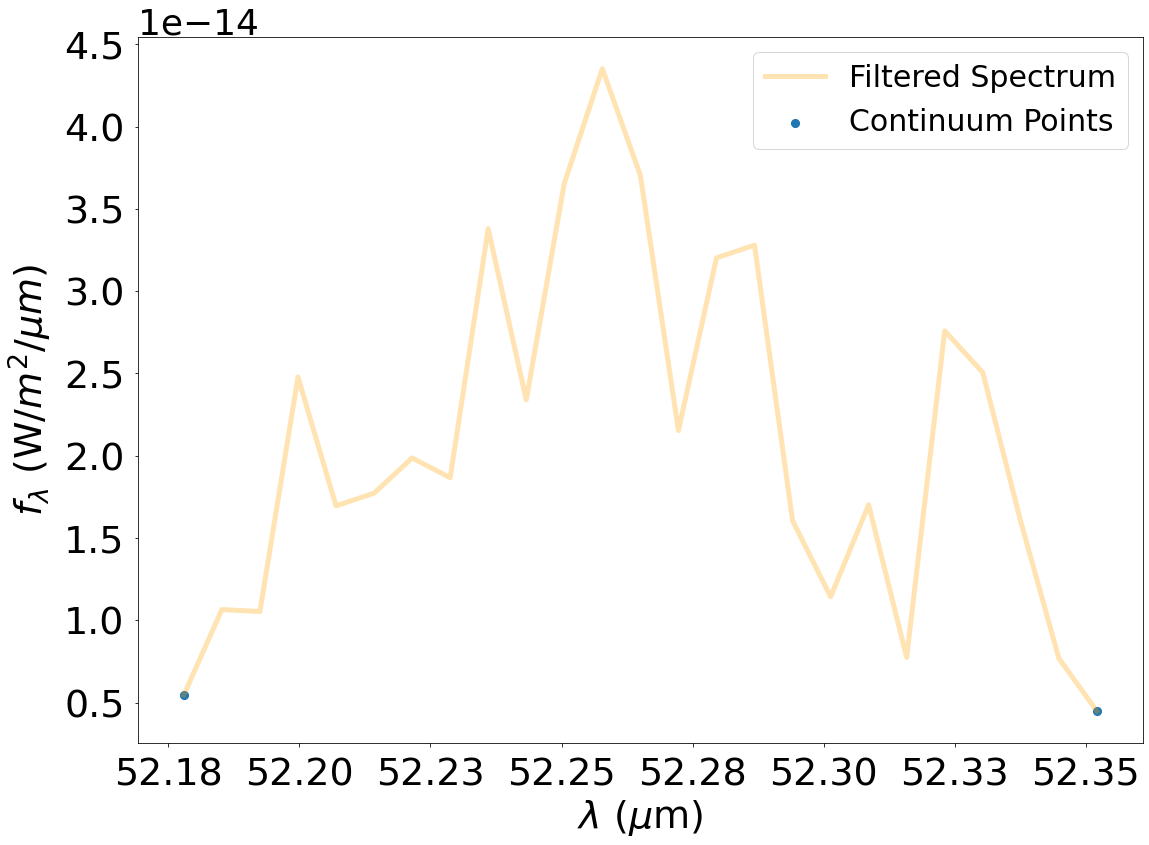

In [46]:
plot_filtered_spectrum_continuum_points(wavelengths_filtered, central_fluxes_filtered,
                                           central_fluxes_filtered_continuum, savedir)

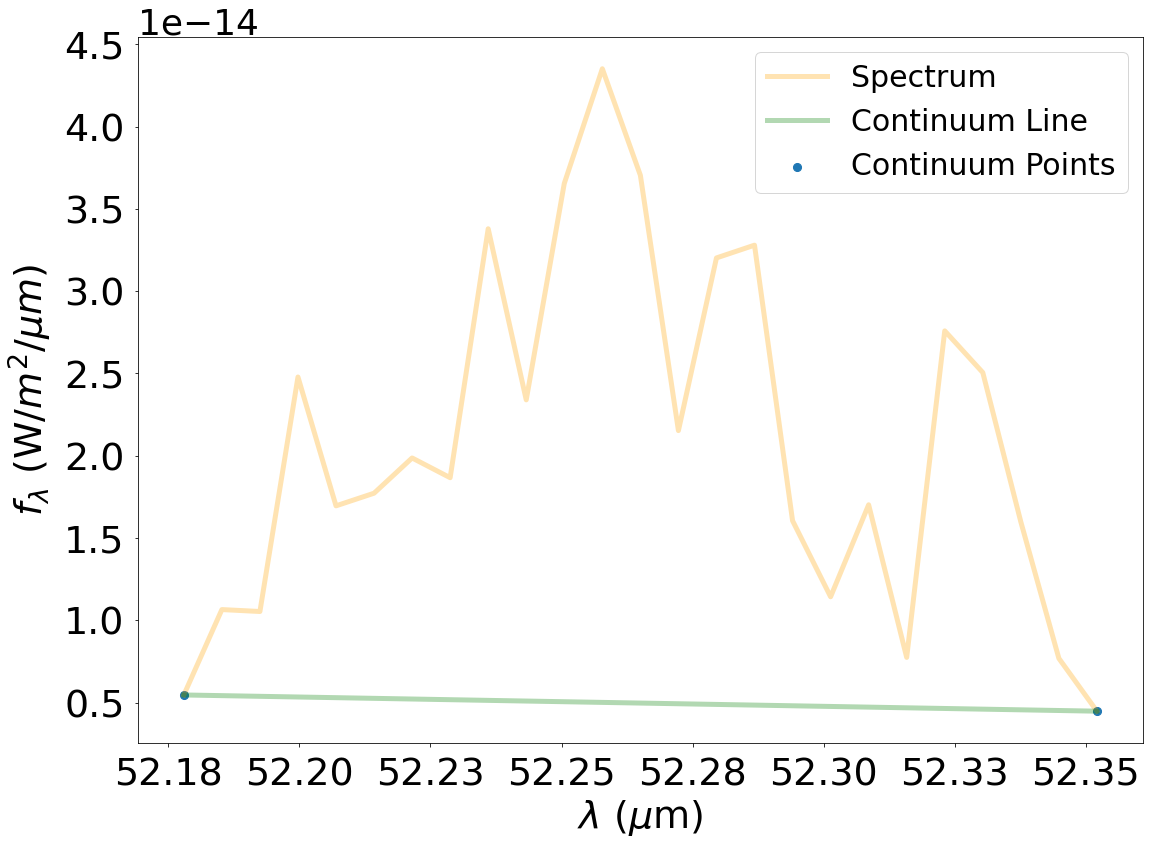

In [47]:
plot_filtered_spectrum_continuum_line(wavelengths_filtered, central_fluxes_filtered,
                                    central_fluxes_filtered_continuum, cont_params, savedir)

In [48]:
wavelengths_act, central_fluxes_continuum_subtracted_act = subtract_continuum(central_fluxes_filtered_continuum, 
                                                                              cont_params, wavelengths_filtered, 
                                                                              central_fluxes_filtered)

In [49]:
fit_params = fit_gaussian(wavelengths_act, central_fluxes_continuum_subtracted_act)

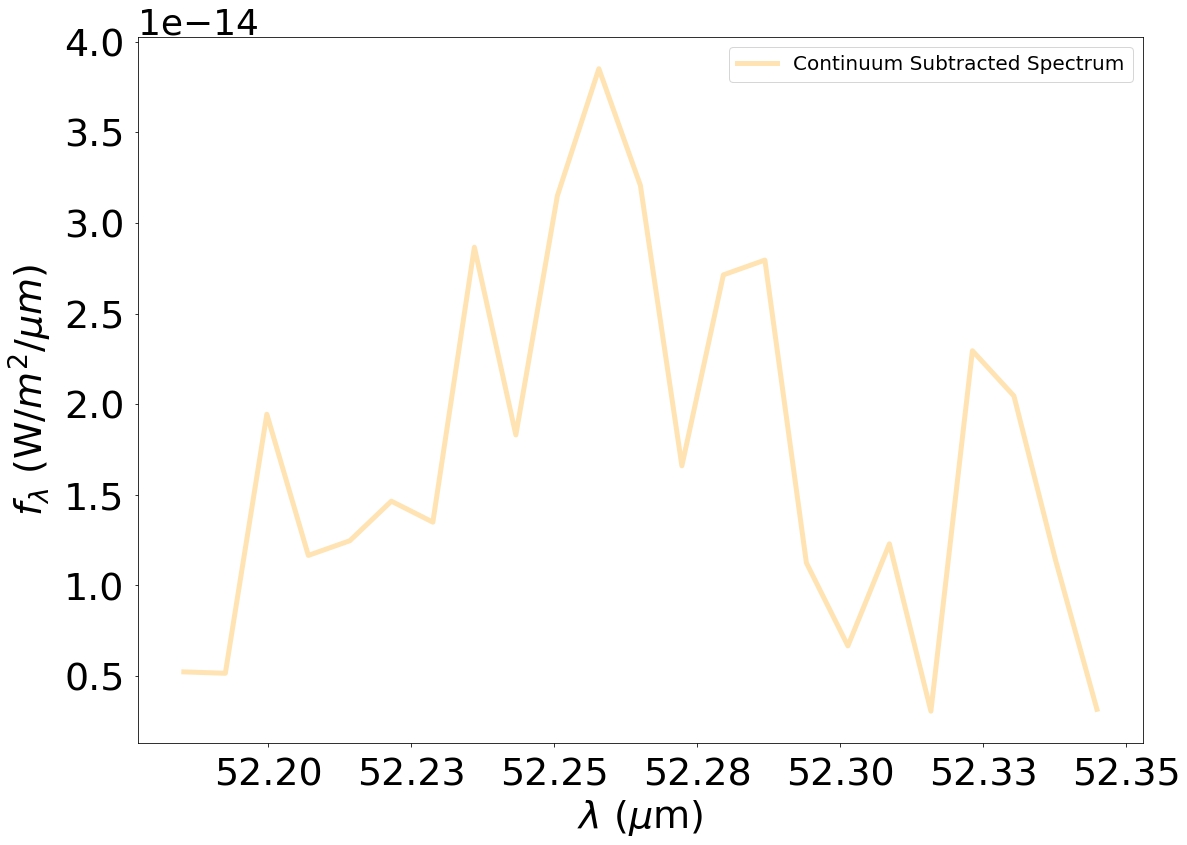

In [50]:
plot_continuum_subtracted_spectrum(wavelengths_act, central_fluxes_continuum_subtracted_act, savedir)

In [51]:
wavelength_range, cont_line_filtered, fitted_central_fluxes_act = overlay(wavelengths_filtered, fit_params)

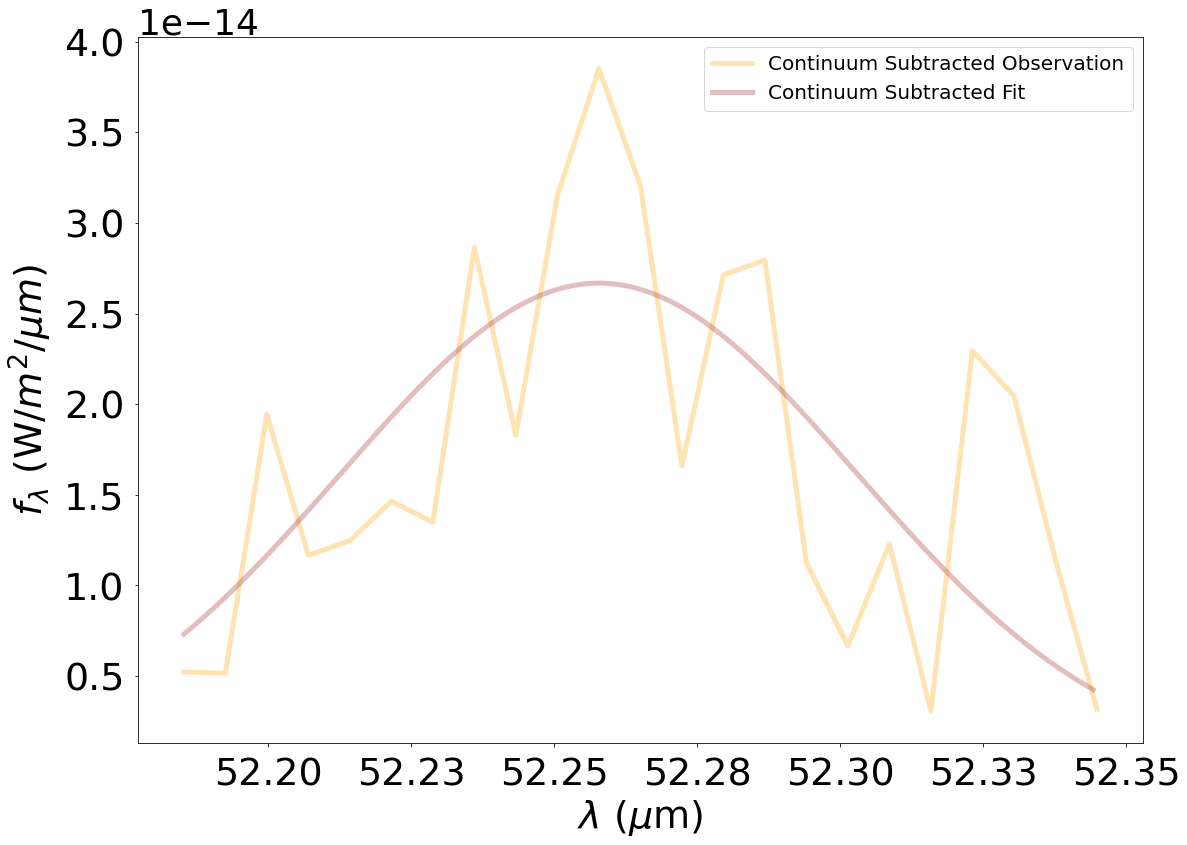

In [52]:
plot_fit_continuum_subtracted_spectrum(wavelengths_act, fit_params, central_fluxes_continuum_subtracted_act, savedir)

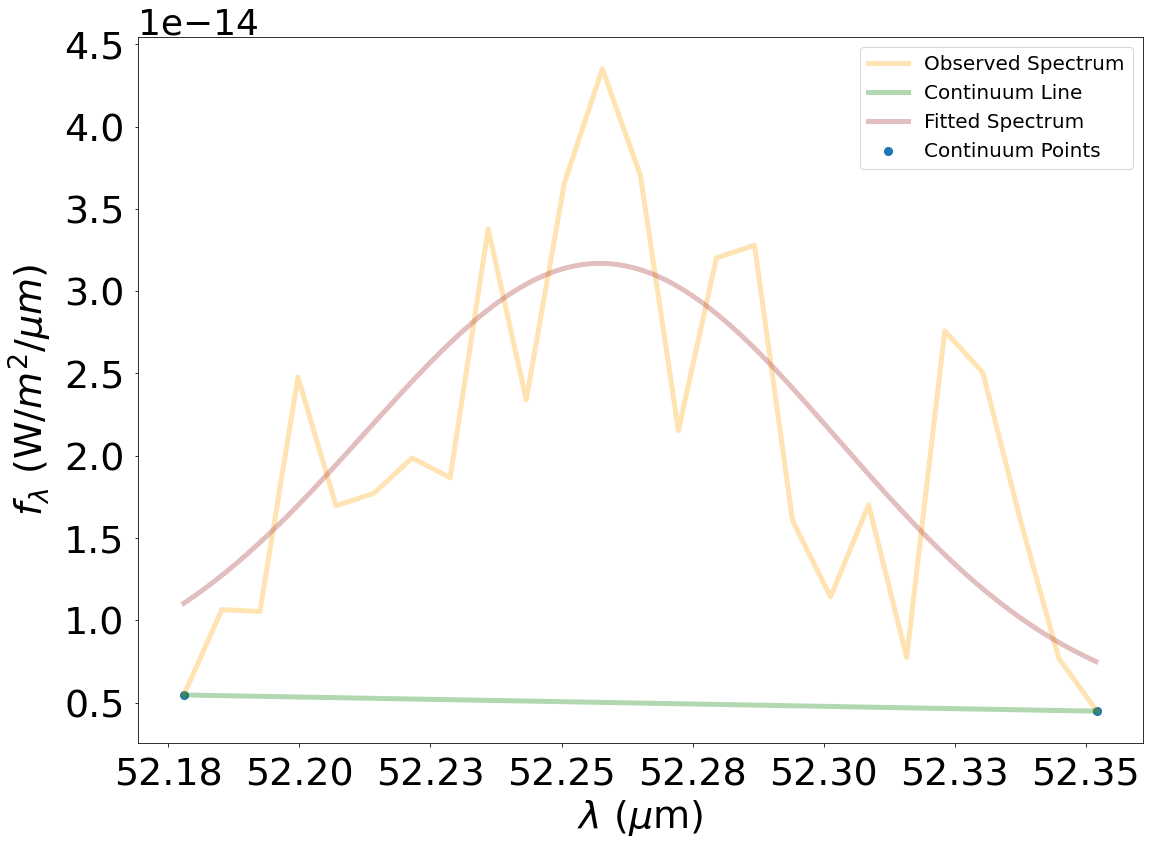

In [53]:
plot_final_spectrum(wavelengths_filtered, cont_params, fit_params, savedir)

In [54]:
flux_continuum, flux_obs, flux_obs_sub, flux_fit, flux_fit_sub = compute_fluxes(wavelengths_filtered, 
                                                                                wavelength_range, 
                                                                                cont_line_filtered, 
                                                                                central_fluxes_filtered, 
                                                                                fitted_central_fluxes_act)

In [55]:
print(flux_continuum)
print(flux_obs)
print(flux_obs_sub)
print(flux_fit)
print(flux_fit_sub)

8.646921893606859e-16
3.7257241726685525e-15
2.861031983307867e-15
3.709733709701397e-15
2.8450415203407113e-15


In [56]:
f = open(savedir + "measurements.txt".format(str(r)), "w")
f.write(str(flux_continuum) + ' ,' + str(flux_obs) + ' ,' + str(flux_obs_sub) + ' ,' + 
        str(flux_fit) + ' ,' + str(flux_fit_sub) + ' ,' + 
       str(2*np.sqrt(np.log(2))*fit_params[2]))
f.close()